In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import random
from PIL import Image

In [4]:
# Definicija putanja za treniranje i testiranje
data_path = 'data_set'  # Promeni putanju ako je drugačija
train_path = os.path.join(data_path, 'test')
test_path = os.path.join(data_path, 'train')

In [5]:
# Data augmentacija i transformacije
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # Nasumično horizontalno ogledanje
    transforms.RandomRotation(10),  # Nasumična rotacija do 10 stepeni
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Učitavanje podataka
train_dataset = ImageFolder(root=train_path, transform=transform_train)
test_dataset = ImageFolder(root=test_path, transform=transform_test)


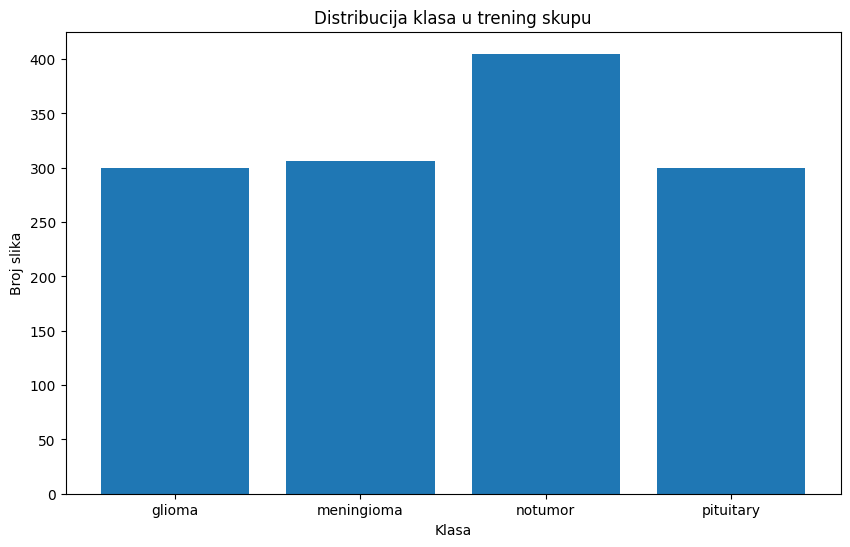

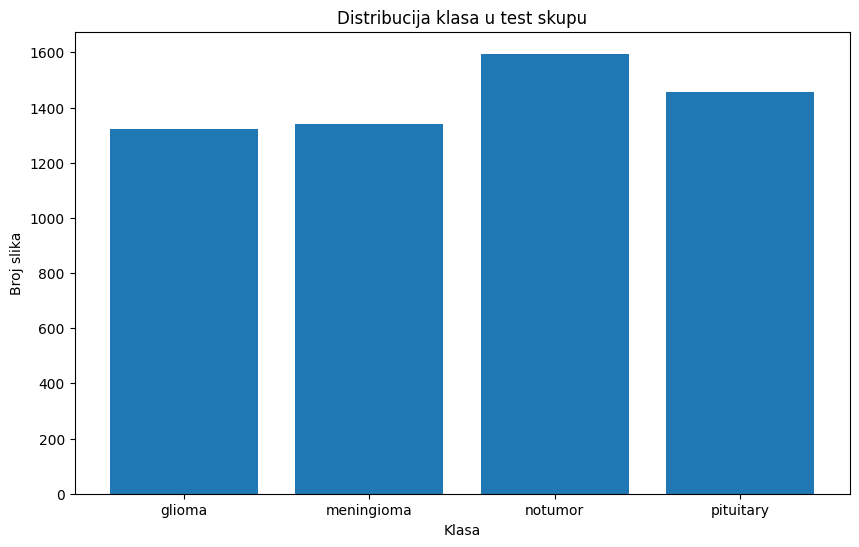

In [6]:
# Vizualizacija broja slika u klasama
def plot_class_distribution(dataset, title):
    class_counts = [len(np.where(np.array(dataset.targets) == i)[0]) for i in range(len(dataset.classes))]
    plt.figure(figsize=(10, 6))
    plt.bar(dataset.classes, class_counts)
    plt.title(title)
    plt.xlabel('Klasa')
    plt.ylabel('Broj slika')
    plt.show()

plot_class_distribution(train_dataset, 'Distribucija klasa u trening skupu')
plot_class_distribution(test_dataset, 'Distribucija klasa u test skupu')

In [7]:
# Kreiranje DataLoader-a
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [8]:
# Kreiranje ResNet18 modela
model = models.resnet18(pretrained=True)

# Prilagođavanje zadnjeg sloja za našu klasifikaciju
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  # 4 klase: glioma, meningioma, notumor, pituitary


/home/teki/Documents/brain_mri/venv_master/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/teki/Documents/brain_mri/venv_master/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Provera dostupnosti CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/home/teki/Documents/brain_mri/venv_master/lib/python3.12/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# Definisanje funkcije gubitka i optimizatora
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Funkcija za treniranje modela
def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validacija
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(test_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoha {epoch+1}/{num_epochs}, Trening gubitak: {epoch_loss:.4f}, Validacioni gubitak: {val_loss:.4f}, '
              f'Trening tačnost: {train_accuracy:.2f}%, Validaciona tačnost: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [16]:
print(torch.cuda.is_available())  # Trebalo bi da vrati True ako je GPU dostupan
print(torch.cuda.device_count())  # Broj dostupnih CUDA uređaja

False
1


In [ ]:
import torch
print(torch.cuda.is_available())
#d

False


import torch
print(torch.cuda.is_available())

In [ ]:
import torch
print(torch.cuda.is_available())

False


In [17]:
# Treniranje modela
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, device)

Epoha 1/10, Trening gubitak: 0.8472, Validacioni gubitak: 0.4617, Trening tačnost: 65.22%, Validaciona tačnost: 83.75%
Epoha 2/10, Trening gubitak: 0.3703, Validacioni gubitak: 0.3122, Trening tačnost: 87.11%, Validaciona tačnost: 88.73%
Epoha 3/10, Trening gubitak: 0.2596, Validacioni gubitak: 0.2554, Trening tačnost: 90.54%, Validaciona tačnost: 90.51%
Epoha 4/10, Trening gubitak: 0.1954, Validacioni gubitak: 0.2336, Trening tačnost: 93.44%, Validaciona tačnost: 91.19%
Epoha 5/10, Trening gubitak: 0.1240, Validacioni gubitak: 0.2170, Trening tačnost: 95.96%, Validaciona tačnost: 91.88%
Epoha 6/10, Trening gubitak: 0.1130, Validacioni gubitak: 0.1926, Trening tačnost: 96.80%, Validaciona tačnost: 93.43%
Epoha 7/10, Trening gubitak: 0.0849, Validacioni gubitak: 0.1815, Trening tačnost: 97.41%, Validaciona tačnost: 93.24%
Epoha 8/10, Trening gubitak: 0.0586, Validacioni gubitak: 0.1642, Trening tačnost: 98.55%, Validaciona tačnost: 94.36%
Epoha 9/10, Trening gubitak: 0.0540, Validacioni

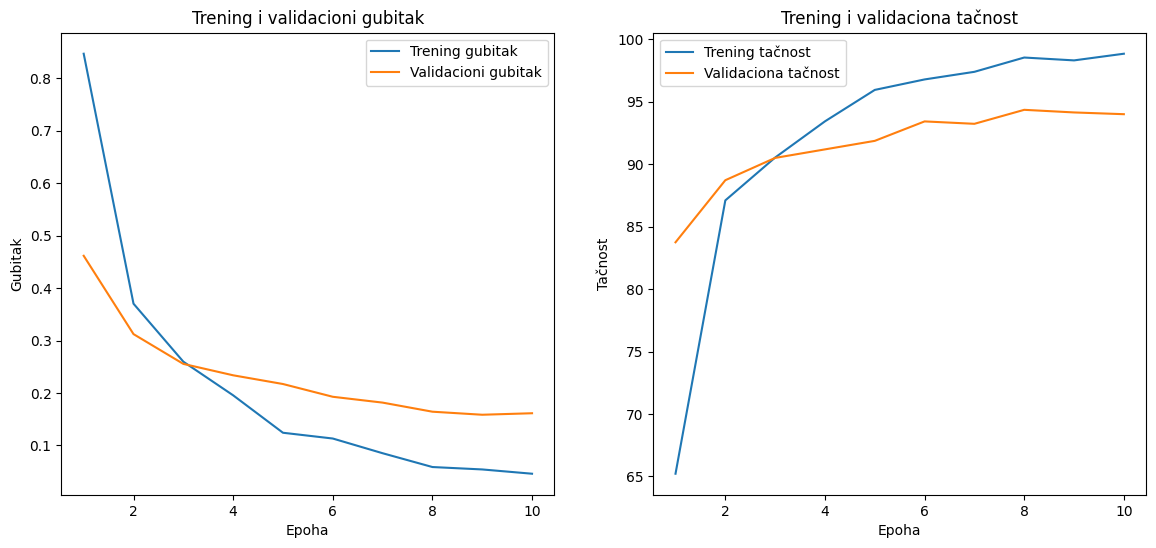

In [18]:
# Crtanje grafika za gubitak i tačnost
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Trening gubitak')
    plt.plot(epochs, val_losses, label='Validacioni gubitak')
    plt.xlabel('Epoha')
    plt.ylabel('Gubitak')
    plt.title('Trening i validacioni gubitak')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Trening tačnost')
    plt.plot(epochs, val_accuracies, label='Validaciona tačnost')
    plt.xlabel('Epoha')
    plt.ylabel('Tačnost')
    plt.title('Trening i validaciona tačnost')
    plt.legend()

    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


In [19]:
# Evaluacija modela
def evaluate_model_with_report(model, test_loader, device, class_names):
    model.eval()  # Evaluacioni mod
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct_test / total_test
    print(f'Test gubitak: {test_loss:.4f}, Test tačnost: {test_accuracy:.2f}%')
    
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

Test gubitak: 0.1612, Test tačnost: 94.01%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.94      0.94      1321
  meningioma       0.89      0.89      0.89      1339
     notumor       0.99      0.95      0.97      1595
   pituitary       0.92      0.98      0.95      1457

    accuracy                           0.94      5712
   macro avg       0.94      0.94      0.94      5712
weighted avg       0.94      0.94      0.94      5712



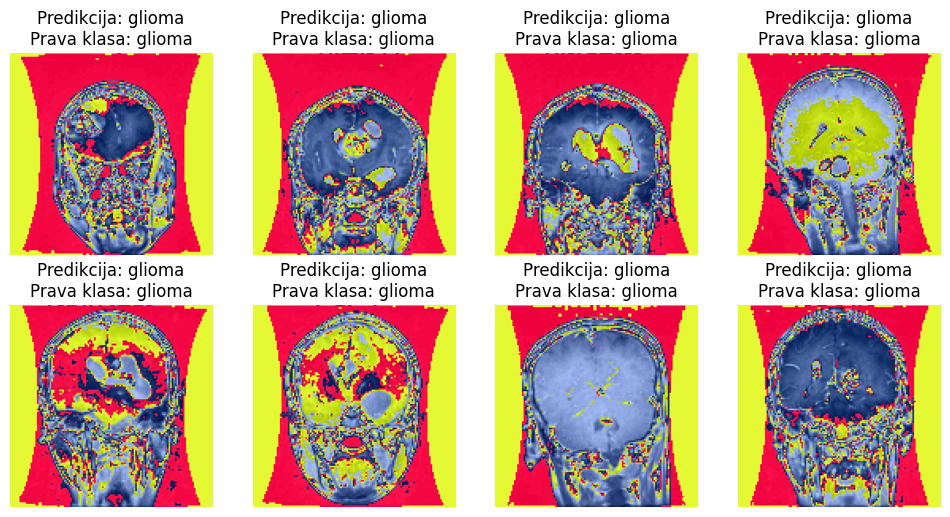

In [20]:
# Imena klasa
class_names = train_dataset.classes
evaluate_model_with_report(model, test_loader, device, class_names)

# Prikaz slika sa predikcijama
def show_predictions(model, dataloader, class_names, device):
    model.eval()
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    fig = plt.figure(figsize=(12, 6))
    for idx in range(min(8, len(images))):
        ax = plt.subplot(2, 4, idx+1)
        img = transforms.ToPILImage()(images[idx].cpu())
        ax.imshow(img)
        ax.set_title(f'Predikcija: {class_names[preds[idx]]}\nPrava klasa: {class_names[labels[idx]]}')
        ax.axis('off')
    plt.show()

show_predictions(model, test_loader, class_names, device)